Pendulum is an OpenAI gym environment wherein you apply continuous force that moves a pendulum to the left or right. The agent must be trained to exert the correct amount of force so that the pendulum balances upright without falling over. The rewards, states, and actions are continuous. So Q-learning will not work. We need to use policy gradients.

A visualization of the environment can be found here:
https://blog.paperspace.com/content/images/2018/12/freegifmaker.me_2dR21.gif

The action in the environment is 1D and exerts a force to the left or right with respect to a pivot point (otherwise known as an actuator in robotics).


Install required dependencies

pip install gym
pip install matplotlib

In the code below, areas marked FFF should be completed by you.

In [8]:
# imports
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch
from torch.distributions import Normal
import torch.nn.functional as F

device = torch.device("cpu")

We are going to define an Actor and a Critic Net. The actor will learn to approximate the value. The critic will try to satisfy the actor with policy gradients. This is the most basic form of policy gradients.

In [9]:
class ActorNet(nn.Module):
    def __init__(self, input_size, num_actions, hidden_size=128):
        super(ActorNet, self).__init__()

        self.fc_shared = nn.Linear(input_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, num_actions)
        self.fc_log_std = nn.Linear(hidden_size, num_actions)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, state):
        """Forward method implementation."""
        x = self.relu(self.fc_shared(state))

        mu = 2*self.tanh(self.fc_mu(x))
        log_std = self.softplus(self.fc_log_std(x))
        std = torch.exp(log_std)

        gaussian_policy = Normal(mu, std)
        action = gaussian_policy.sample()

        return action, gaussian_policy


Note we learn mu, and sigma, and then we sample from a gaussian with mu and sigma.
We return the sampled action, and the gaussian policy which we can use later to sample the log prob of an action under that gaussian.

The critic estimates the value, similar to a Q-network.


In [10]:
class CriticNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        """Initialize."""
        super(CriticNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, state):
        """Forward method implementation."""
        x = self.relu(self.fc1(state))
        value = self.out(x)
        return value

Below we define the actual A2C agent.

In [11]:
class A2CAgent:
    # def __init__(self, env, gamma=0.9, entropy_weighting=1e-2):
    def __init__(self, env, gamma=.99, entropy_weighting=.1):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weighting = entropy_weighting

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = ActorNet(obs_dim, action_dim).to(device)
        self.critic = CriticNet(obs_dim, hidden_size=64).to(device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action, gaussian_policy = self.actor(state)
        log_prob = gaussian_policy.log_prob(action)
        # You want the probability of the action under this policy.
        # So look into gaussian_policy's log_prob method.
        # https://pytorch.org/docs/stable/distributions.html
        action_np = action.clamp(-2.0, 2.0).cpu().detach().numpy()
        return log_prob, action_np

    def step(self, action):
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, info = self.env.step(action)
        return next_state, reward, terminated

    def update_model(self, state, log_prob, next_state, reward, done):
        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        predicted_value = self.critic(next_state)
        targ_value = reward + self.gamma * predicted_value * mask
        value_loss = F.smooth_l1_loss(predicted_value, targ_value.detach())

        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = targ_value - self.critic(state)
        advantage = advantage.detach()  # not backpropagated
        policy_loss = -log_prob * advantage
        policy_loss += self.entropy_weighting * -log_prob  # entropy maximization. Improves training.

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()

Fancy Plotting Code

In [12]:
def plot_fancy(steps_survived_history, min_reward_offset=800.0):
    plt.figure(2)
    plt.clf()
    #durations_t = torch.FloatTensor(episode_durations)
    steps_survived_history_torch = torch.FloatTensor(steps_survived_history)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(np.array(steps_survived_history))
    # take 100 episode averages and plot them too
    if len(steps_survived_history) >= 20:
        means = steps_survived_history_torch.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19)-min_reward_offset, means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

Main training loop.

In [13]:
def main(total_steps=10000):
    env_id = "Pendulum-v1"
    env = gym.make(env_id)
    state, info = env.reset()
    next_state, reward, terminated, truncated, info = env.step(env.action_space.sample())
    state, info = env.reset()
    state = torch.FloatTensor(state).to(device)
    agent = A2CAgent(env)
    actor_losses, critic_losses, episode_rewards_history = [], [], []
    horizon = 100
    horizon_multiplier = .5
    total_episode_reward = 0

    for current_step in range(0, total_steps):
        log_prob, action = agent.select_action(state)
        next_state, reward, done = agent.step(action)
        next_state = torch.FloatTensor(next_state).to(device)
        actor_loss, critic_loss = agent.update_model(state, log_prob, next_state, reward, done)
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)

        state = next_state
        total_episode_reward += reward


        # if episode ends
        # if done or (current_step % horizon == 0 and current_step > 1):
        if done or (current_step % (horizon*horizon_multiplier) == 0 and current_step > 1):
            #print("episode terminated")
            state, info = env.reset()
            state = torch.FloatTensor(state).to(device)
            # episode_rewards_history.append(total_episode_reward)
            episode_rewards_history.append(total_episode_reward/horizon_multiplier)
            # plot_fancy(episode_rewards_history)
            print(total_episode_reward/horizon_multiplier)
            total_episode_reward = 0
    plt.plot(range(len(episode_rewards_history)), episode_rewards_history, label='Total episode rewards')
    plt.legend()
    plt.show()
    plt.plot(range(len(actor_losses)), actor_losses, label='Actor Losses')
    plt.legend()
    plt.show()
    plt.plot(range(len(critic_losses)), critic_losses, label='Critic Losses')
    plt.legend()
    plt.show()

-516.5419617589216
-501.2358913672966
-309.48129790947405
-607.9957794781985
-480.7433355242044
-481.71401545186956
-912.425256741927
-764.527359240709
-596.3720564900013
-746.3257289457323
-645.9472406277052
-615.120134910415
-477.0547782780265
-760.8164148351158
-459.22077030382815
-540.5108570120361
-794.6022033098421
-701.0715590565112
-928.9493106593789
-726.7220390876079
-651.7441795707243
-912.3865638034584
-509.62390145247906
-903.6930253570315
-721.3642213596768
-909.9279739464455
-284.4643235599286
-613.0013081467738
-768.3097827047816
-607.2459741547401
-720.3738266794768
-848.8981284298173
-603.7205669259964
-837.7924772862722
-877.9473898712525
-688.6756734240953
-881.9371937852168
-447.57565666580314
-645.8997916998342
-799.5881953543347
-846.814459200683
-656.5752138134826
-761.4262661640322
-637.1135706360303
-472.70585445011733
-690.3699608068025
-766.9656621612047
-776.4425962271075
-683.8547946006613
-894.126892331451
-529.4674727704102
-635.6097976875216
-674.808412

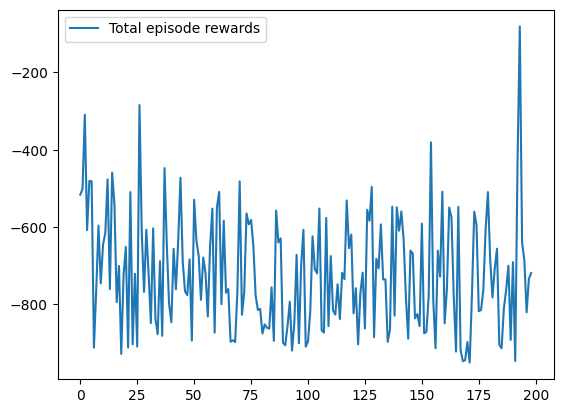

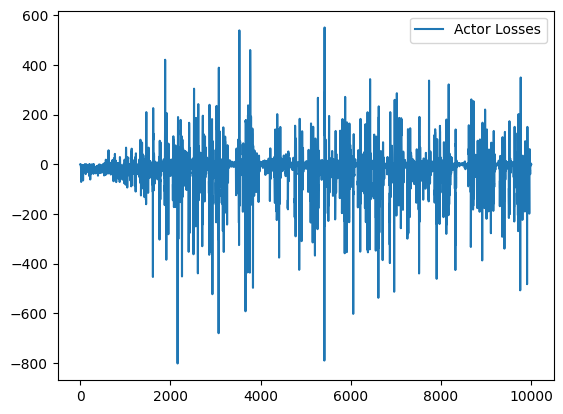

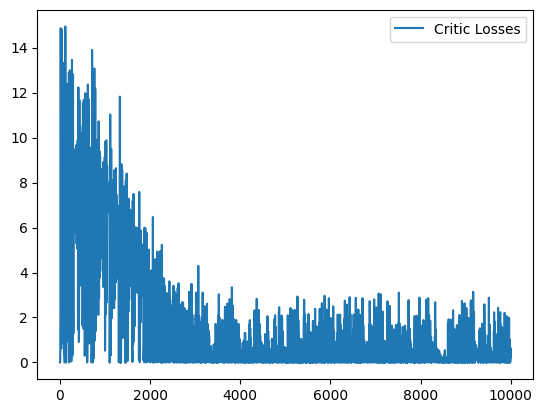

In [14]:
if __name__ == "__main__":
    main()

# Please answer the following questions

# #1 Basic Question

How many states are there? How many actions?


# #2 Complete the code for A2C, filling in all the missing areas in the code above.

Plot the learning curves showing the following:
a) Total episode reward vs time.
b) actor_loss vs time.
c) critic_loss vs time.

# #3 Can you do better?

a) What is the impact of the entropy weighting term on training?

b) What is the impact of the episode horizon on training?
Note that increasing the horizon will increase the total accumulated reward, since the trajectories will now be longer. So in answering this question you need to normalize.

c) What is the impact of gamma on training?

Overall, what is the best set of hyper-parameters you found?
